In [ ]:
"""
NOTE: All of this is obselete and this functionality is moved to the DeepRad repo. This is left here for archival purposes only.

Use `python write_floorplan_json --num 5` to generate json here. 
"""

In [78]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..'))
pths = [home]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

import matplotlib.pyplot as plt 
import numpy as np 
from pprint import pprint as pp 
# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from shapely import affinity
import shapely.geometry as geom

from rtree import index
from sklearn.mixture import GaussianMixture
from matplotlib.axes import Axes

from typing import List

def viz_poly_sh_arr(poly_sh_arr, a=None, scale=1, iter=False, **kwargs):
    """Plot shapely polygons"""
    
    n_plots = 1
    if iter:
        n_plots = len(poly_sh_arr)
    if a is None:
        _, a = plt.subplots(1, n_plots, sharey=True)
    
    for i, poly_sh in enumerate(poly_sh_arr):
        if poly_sh.exterior:
            xx, yy = poly_sh.exterior.xy
            xx, yy = np.array(xx), np.array(yy)
            if iter:
                a[i].plot(xx * scale, yy * scale, **kwargs)
            else:
                a.plot(xx * scale, yy * scale, **kwargs)
    if iter:
        a[i].axis('equal')
        return a[i]
    else:
        a.axis('equal')
        return a


def viz_ortho_snap_grid(x_means: np.ndarray, y_means:np.ndarray, ax:Axes, color:str='red', 
                         linewidth:int=2, alpha:float=0.5, **kwargs) -> Axes:
    """Visualize polygon ortho snap grid."""
    
    x_min, x_max = x_means.min(), x_means.max()
    y_min, y_max = y_means.min(), y_means.max()

    # TODO: fix kwargs
    for x_mean, y_mean in zip(x_means, y_means):    
        ax.plot([x_mean, x_mean], [y_min, y_max], color='red', linewidth=2, alpha=0.5, **kwargs)
        ax.plot([x_min, x_max], [y_mean, y_mean], color='red', linewidth=2, alpha=0.5, **kwargs)
    
    return ax
    
def to_poly_sh(xy_arr):
    """Shapely polygon from list of two arrays of x, y coordinates.
    
        Args: 
            xy_arr: [x_arr, y_arr]
    Example: 
        to_poly_sh(to_poly_np(poly_sh))
        to_poly_np(to_poly_sh(poly_np))
    """ 
    return geom.Polygon([(x, y) for x, y in zip(*xy_arr)])

def to_poly_np(poly_sh):
    """Two arrays of x, y coordinates from shapely polygon.

    Example: 
        to_poly_sh(to_poly_np(poly_sh))
        to_poly_np(to_poly_sh(poly_np))
    """ 
    return np.array(poly_sh.exterior.xy)
    
def rooms_equal_color_mapping(_rooms: np.ndarray, _rooms_class_num: int) -> np.ndarray:
    """Replace class indices with equally spaced intervals from 0-255 for thresholding.
        
        Args:
            _rooms: 2d matrix of room image pixels in np.uint8. 
            _rooms_class_num: Number of classes, equivalent to 
                `np.unique(_rooms)'.

        Returns:
            _rooms: 2d matrix of room image pixels with indices
                mapped between 0-255.  

    """

    if (len(_rooms.shape) != 2) or (not _rooms.dtype == np.uint8):
        raise Exception('_rooms expects 2D matrix of dtype np.uint.'
            'Got: {} shape and {} dtype.'.format(_rooms.shape, _rooms.dtype)) 

    N = _rooms_class_num
    
    # Color val calculation
    color_interval = 255 / (N - 1)
    color_vals = (np.arange(N) * color_interval).astype(np.uint8)
    #color_vals = (np.ones(N) * 50).astype(np.uint8)

    # Replace room indices with colors
    for i, v in zip(room_classes, color_vals):
        _rooms = np.where(_rooms == i, v, _rooms)
    
    return _rooms

def contiguous_ones_idx(bit_arr: np.ndarray) -> np.ndarray:
    """Find indices of contiguous (repeated) ones in bit array.

    Given binary array (0s, 1s), returns (start, end) indices of
    repeated blocks of ones:

    bin_arr = np.array([1, 0, 0, 1, 0, 0, 1, 1])
    contiguous_ones_idx(bin_arr) -> [[0, 1] [3, 4] [6, 8]]
    """
    bit_arr = (bit_arr / bit_arr.max()).astype(np.bool)
    bit_arr = np.concatenate(([0], bit_arr, [0]))
    diff = np.abs(np.diff(bit_arr))
    zero_idx = np.where(diff == 1)[0].reshape(-1, 2)
    return zero_idx


def whitespace_pixel_dist(pixel_arr, viz=False, **kwargs):
    """Return distance whitespace as array from 1d pixel array."""
    pixel_arr = pixel_arr.astype(int)
    zz = np.ones((int(np.round(pixel_arr.max())) + 1)).astype(np.bool)
    zz[pixel_arr] = 0
    white_space_idx = contiguous_ones_idx(zz)
    white_space_idx.T

    if viz:
        _, a = plt.subplots()
        a.imshow(np.array([zz] * 10), **kwargs)
    
    # distance of white space. Less then 16 = close
    pix_gap = white_space_idx[:, 1] - white_space_idx[:, 0]
    return pix_gap 

def contour_to_poly_np(pt):
    """opencv to polygon array."""
    pt = pt.T[:, 0]
    x, y = pt
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    return np.array([x, y])

def contour_arr_from_bit_image(_img, threshold=False):
    """Get opencv contours from binary (black/white) raster image."""

    # Optional ways to preprocess image for thresholding. 
    if threshold:
        block_size = 5 # size of pixel neighborhood for threshold
        bias = 0 # subtract from mean
        _thresh = cv2.adaptiveThreshold(
            _img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, bias)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
        _img = cv2.dilate(_thresh, kernel).copy()
    _, _contours, hier = cv2.findContours(_img, cv2.RETR_CCOMP, 
                                          cv2.CHAIN_APPROX_SIMPLE)
    # hier = hier[0]
    return _contours

def clean_poly_sh(poly_sh, buffer_epsilon, simplify_tol, convex_diff_pct=0.1):
    """Applies methods to clean shapely geometry. 

    Simplfiies w/ tolerance, buffers, and checks ccw orientation.
    """

    if simplify_tol:
        poly_sh = poly_sh.simplify(simplify_tol, preserve_topology=True)
    # Buffer in/out to remove some geometric flaws
    poly_sh = poly_sh.buffer(buffer_epsilon).buffer(-buffer_epsilon)
    
    if np.abs(poly_sh.area) < 1e-10:
        return None

    # Replace with convex hull if only small change in area.
    diff_poly_sh = poly_sh.convex_hull.difference(poly_sh)
    diff_ptc = diff_poly_sh.area / poly_sh.area
    if 0.0 < diff_ptc < convex_diff_pct:
        poly_sh = poly_sh.convex_hull
    
    if not poly_sh.exterior.is_ccw:
        poly_sh = geom.polygon.orient(poly_sh, sign=1.0)
    
    return poly_sh

def poly_sh_rtree(poly_sh_arr):
    ridx = index.Index()
    for i, poly_sh in enumerate(poly_sh_arr):
        ridx.insert(i, poly_sh.bounds)
    return ridx 

def almost_equals(poly1: np.ndarray, poly2: np.ndarray, 
                  equal_tol:float=2.0, scale:float=1.0) -> bool:
    """Check if duplicate polygon."""
    
    poly1, poly2 = poly1.T, poly2.T
    equal_tol /= scale
    poly1_pts_num, poly2_pts_num = poly1.shape[0], poly2.shape[0]
    if poly1_pts_num != poly2_pts_num:
        return False

    pt1_idx, pt2_idx = None, None
    for i, pt1 in enumerate(poly1):
        for j, pt2 in enumerate(poly2):
            if np.allclose(pt1, pt2, atol=equal_tol):
                pt1_idx, pt2_idx = i, j
                break
    
    if pt1_idx is None:
        return False

    if pt1_idx != 0:
        poly1_idxs = list(range(poly1_pts_num))
        poly1_idxs = poly1_idxs[:pt1_idx] + poly1_idxs[pt1_idx:]
        poly1 = poly1[poly1_idxs]

    if pt2_idx != 0:
        poly2_idxs = list(range(poly2_pts_num))
        poly2_idxs = poly2_idxs[:pt2_idx] + poly2_idxs[pt2_idx:]
        poly2 = poly2[poly2_idxs]
  
    return np.allclose(poly1, poly2, atol=equal_tol)

def filter_parent_polys(polys_sh):
    """Check if rtree contains polygon.
    
    Args:
        keep_equal_child: bool to indicate to replace parent with child
    """
    polys_sh = [p.buffer(0) for p in polys_sh]
    ridx = poly_sh_rtree(polys_sh)
    _polys_sh = []
    for poly_sh in polys_sh:
        hits = ridx.contains(poly_sh.bounds)
        hits = list(hits)

        # get rid of false positives
        hits = [h for h in hits if poly_sh.contains(polys_sh[h].buffer(-0.5 * image_scale))]
        
        if len(hits) <= 1:
            # child polygons, 1 indicates they contain themselves  
            _polys_sh.append(poly_sh)
    
    return _polys_sh

def filter_duplicate_polys(ridx, polys_sh, equal_tol=1.0, scale=1.0):
    """Check for duplicate polygons."""
    
    equal_tol /= scale
    _polys_sh, _dups = [], set()
    num_polys = len(polys_sh)
    polys_sh_np = [to_poly_np(poly_sh) for poly_sh in polys_sh]
    
    for i, (poly_sh_np, poly_sh) in enumerate(zip(polys_sh_np, polys_sh)):
        
        if i in _dups:
            continue

        hits = ridx.intersection(poly_sh.bounds)
        dups_hits = [h for h in hits 
                     if almost_equals(poly_sh_np, polys_sh_np[h], equal_tol)]
        
        # add poly to list
        _polys_sh.append(poly_sh)
        # add potential duplicates to set
        _dups |= set(dups_hits)

    return _polys_sh

def filter_by_size(poly_sh_arr, area_tol=None, side_tol=None, scale=1.0):
    
    def _is_side_fx(side_tol, scale):
        def _is_side_fx_helper(p):
            minx, miny, maxx, maxy = p.bounds
            width, height = (maxx - minx) * scale, (maxy - miny) * scale
            return width > side_tol and height > side_tol
        return _is_side_fx_helper

    if area_tol:
        poly_sh_arr = [p for p in poly_sh_arr if (p.area * scale) > area_tol]
    
    if side_tol:
        is_side_fx = _is_side_fx(side_tol, scale)
        poly_sh_arr = [p for p in poly_sh_arr if is_side_fx(p)]
    
    return poly_sh_arr

def gauss_mixture_1d(pts_1d: np.ndarray, n_components: float=10, 
                     init_var: float=0.5, random_seed=None) -> GaussianMixture:
    """Get 1d gaussian mixture model from 1D points along x-axis.
    
        Args: 
            pts_1d: (n_pts, 2) array of np.float64 type. Points must be projected onto x-axis.
            n_components: Number of clusters. Default 10.
            init_var: Variance to initialize variance of x-axis. Default is 0.5, which is 
                wider then tolerance for points indicate. 
            random_seed: Integer for random seed, default is None.        
        Returns:
            GaussianMixture model of 1D clusters. 
    """
    
    if (len(pts_1d.shape) != 2) or (pts_1d.shape[1] != 2) or (not pts_1d.dtype == np.float64):
        raise Exception('pts_1d must be a 2D float array of shape (n_pts, 2). '
            'Got: {} shape of type {}.'.format(pts_1d.shape, pts_1d.dtype))

    if not np.allclose(pts_1d[:, 1], np.zeros_like(pts_1d.shape[0]), 1e-10):
        raise Exception('pts_1d must be projected to x-axis, got non-zero values on y-axis.')

    # 2x average sum of squares from cluster to pt w/i tol
    precs = np.ones((n_components, 2)) * 1e-10
    precs[:, 0] = 1 / init_var  # 1d variance, wider works better

    gauss_model = GaussianMixture(
        n_components=n_components, covariance_type='diag', 
        random_state=random_seed, warm_start=True, 
        precisions_init=precs)

    return gauss_model.fit(pts_1d)

def estimate_1d_cluster_num(xproj: np.ndarray, yproj: np.ndarray, gap_tol: float, 
                            viz:bool=False) -> np.ndarray:
    """Estimate x andy components from x and y projection and gap filtering.
    
    Args:
        xproj: A (N, 2) array of points with y axis-0.
        yproj: A (N, 2) array of points with x axis=0.
        gap_tol: float 

    Returns:
        Two numbers for x and y cluster component numbers.

    """
    # Calc distance of white spaces
    x_white_dist_arr = whitespace_pixel_dist(xproj[:, 0], viz=viz)
    y_white_dist_arr = whitespace_pixel_dist(yproj[:, 1], viz=viz)
    
    # Cluster components by filtering out small gaps
    x_comp = np.where(x_white_dist_arr > gap_tol)[0].size
    y_comp = np.where(y_white_dist_arr > gap_tol)[0].size 

    return x_comp, y_comp 

def xy_projection(poly_sh_arr):
    """Produces two 2d arrays of x, y points, where one axis is 0."""
    # Get model points
    _xproj = np.concatenate([to_poly_np(poly_sh)[0] for poly_sh in poly_sh_arr])
    _yproj = np.concatenate([to_poly_np(poly_sh)[1] for poly_sh in poly_sh_arr])

    # Create 2D x, y projection matrices
    n_pts = _xproj.shape[0]
    xproj, yproj = np.zeros((n_pts, 2)), np.zeros((n_pts, 2))
    xproj[:, 0] = _xproj 
    yproj[:, 1] = _yproj
    
    return xproj, yproj


def move_poly_sh_arr(poly_sh_arr, xdim=None, ydim=None):
    """Moves multiple poly_sh by xdim, ydim.
    
    If None for xdim or ydim, that axis will be moved to origin.
    """

    if xdim is None or ydim is None:
        xproj, yproj = xy_projection(poly_sh_arr)
        xdim = -xproj[:, 0].min() if xdim is None else xdim
        ydim = -yproj[:, 1].min() if ydim is None else ydim
    
    return [affinity.translate(p, xdim, ydim) for p in poly_sh_arr]


def get_cluster_coord_fx(x_gauss_mod, y_gauss_mod):
    """Get fx coordinates of closest cluster for polygon pts from gaussian mixture model."""
    x_means = x_gauss_mod.means_[:, 0]
    y_means = y_gauss_mod.means_[:, 0]
    def _get_cluster_coord_fx(polyc):
        polyc_xproj = np.array([polyc[:, 0], np.zeros_like(polyc[:, 0])]).T
        polyc_yproj = np.array([polyc[:, 1], np.zeros_like(polyc[:, 1])]).T
        x_clusters = x_gauss_mod.predict(polyc_xproj)
        y_clusters = y_gauss_mod.predict(polyc_yproj)
        return np.array([x_means[x_clusters], y_means[y_clusters]])
    return _get_cluster_coord_fx


def abbreviated_floorplan_dict(floorplan_dict):
    """Creates a lightweight dictionary representation of floor image and vector data.

    Args:
        floorplan_dict: Raw floorplan dictionary from FloorplanSVG class.
            .. code-block:: python
                {
                'image': img,
                'label': label,
                'folder': self.folders[index],
                'heatmaps': heatmaps,
                'scale': coef_width,
                'house': house
                }

    Returns:
        Abbreviated dictionary of floorplan data for BEM generation.
            .. code-block:: python
                {
                'scale': Float to scale unscaled image to normalized scaled image for CNN input.
                'img': Original floorplan image.
                'label': Labeled floorplan image.
                'wall_vecs': Wall vector data.
                'window_vecs': Window vector data.
                'door_vecs': Door vector data.
                }
        """

    hdata = floorplan_dict
    # hdata['scale']: img_orig / img_scaled, so multiply by scale goes back to orig
    abbrev_floorplan_dict = {
        'scale': hdata['scale'],
        'img': hdata['image'].permute(1, 2, 0).data.cpu().numpy() / 255.0,
        'label': hdata['label'].data.cpu().numpy()[0].astype(np.uint8),
        # get vector representations for scaling
        'walls': hdata['house'].representation['walls'],
        'windows': hdata['house'].representation['windows'],
        'doors': hdata['house'].representation['doors']
    }

    return abbrev_floorplan_dict

In [80]:
from floortrans.loaders.svg_loader import FloorplanSVG
import cv2 

from floortrans.plotting import discrete_cmap
discrete_cmap()
from copy import copy

figsize_default = np.array((5, 5))


In [81]:
idx = 16
hdatas = FloorplanSVG(data_folder, 'test.txt', format='txt', original_size=True)
hdata = hdatas.get_data(idx)
hdict = abbreviated_floorplan_dict(hdata)

# Extract data
scale = hdict['scale']
img = hdict['img']
_rooms = hdict['label']
walls = hdict['walls']
winds = hdict['windows']
doors = hdict['doors']


0 Background; 1 Outdoor; 2 Wall; 3 Kitchen; 4 Living Room; 6 Bath; 8 Railing; 11 Undefined; 

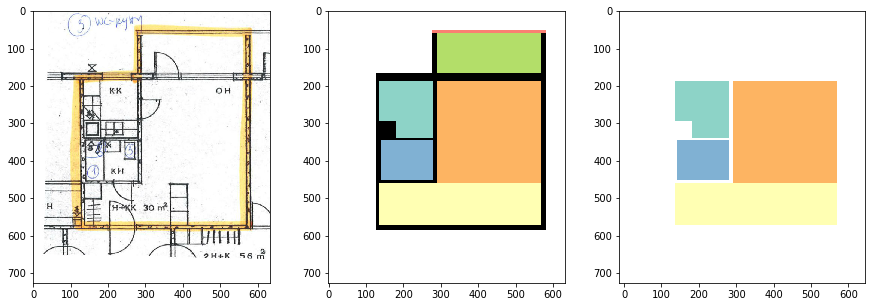

In [82]:
room_classes_idx = np.unique(_rooms)
classes = [room_classes[i] for i in room_classes_idx]
for i, class_ in zip(room_classes_idx, classes):
    print(i, class_, end='; ')

# remove balconies, railings, and walls
_rooms_orig = copy(_rooms)
_rooms = np.where(_rooms == 1, 0, _rooms)
_rooms = np.where(_rooms == 8, 0, _rooms)
_rooms = np.where(_rooms == 2, 0, _rooms)

# Plot images
_, a = plt.subplots(1, 3, figsize=(figsize_default[0] * 3, figsize_default[1]))
a[1].imshow(_rooms_orig, cmap='rooms')
a[2].imshow(_rooms, cmap='rooms')
a[0].imshow(img)
_ = a[2].axis('equal')

bld width: 6.87m


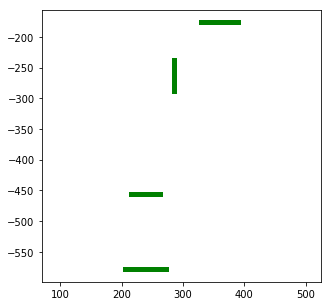

In [83]:
f, a = plt.subplots(1,1, figsize=figsize_default)
door_lens = []
for x in doors:
    pts, label = x[0], x[1]
    pts = np.array(pts) * scale
    door_vec = pts[1] - pts[0]
    door_len = np.sum(door_vec ** 2) ** 0.5
    door_lens.append(door_len)
    X = pts[:, 0]
    Y = -pts[:, 1]
    a.plot(X, Y, 'green', linewidth=5)

a.axis('equal')
door_lens = np.array(door_lens)
meter_scale = 0.9 / door_lens.mean()
image_scale = 1 / meter_scale

# Gut check the scale
_dim = np.where(np.sum(_rooms, axis=0) > 1, 0, 1)
_dim = contiguous_ones_idx(_dim)
diff = _dim[:, 1] - _dim[:, 0]
diff = np.diff(_dim, n=1, axis=1).ravel()
_dim = _rooms.shape[1] - np.sum(diff)
print('bld width: {}m'.format(np.round(_dim * meter_scale, 2)))


In [53]:
room = _rooms.astype(np.float64)
dx = np.abs(np.diff(room, axis=0, prepend=0.0))
dy = np.abs(np.diff(room, axis=1, prepend=0.0))
diff = dx + dy
diff = np.where(diff > 0, 255, 0)
threshed_rooms = diff.astype(np.uint8)

#_, a = plt.subplots(figsize=figsize_default)
#a.imshow(room)

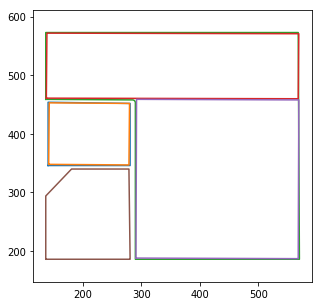

In [84]:

_contour_arr = contour_arr_from_bit_image(threshed_rooms, threshold=True)[:-1]
_poly_np_arr = [contour_to_poly_np(contour) for contour in _contour_arr]

# Rescale
#pts_arr = np.array([j for i in _poly_np_arr for j in i.T])
#minx, miny = pts_arr[:, 0].min(), pts_arr[:, 1].min()
#print(minx, miny)
#print(np.array([_poly_np_arr[0][0] - minx, _poly_np_arr[0][1] - miny]))

# TODO: make this into smaller fx
_poly_sh_arr = [to_poly_sh(poly_np) for poly_np in _poly_np_arr]

beps, stol, dpct = 5, 0.25 * image_scale, 0.05
_clean_poly_sh = lambda p: clean_poly_sh(p, beps, stol, dpct)
_poly_sh_arr = [_clean_poly_sh(_poly_sh) for _poly_sh in _poly_sh_arr]

#print(len(_poly_sh_arr))
_, a = plt.subplots(figsize=figsize_default)
a = viz_poly_sh_arr(_poly_sh_arr, a)


num @ 6
Removed: 0 duplicates; num @ 6
Removed: 0 smalls; num @ 6
Removed: 2 parents; num @ 4
num:  4


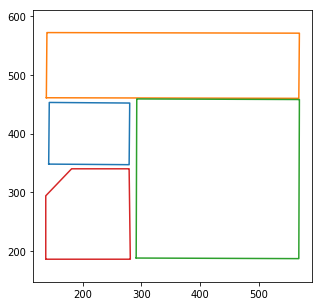

In [85]:
# Filter polygon checks
poly_sh_arr = _poly_sh_arr
n_poly_sh = len(poly_sh_arr)
ridx = poly_sh_rtree(poly_sh_arr)
print('num @', n_poly_sh)

# TODO: set scale tol
gap_tol = 1.0 * image_scale
poly_sh_arr = filter_duplicate_polys(ridx, poly_sh_arr, gap_tol)
_dup_diff = n_poly_sh - len(poly_sh_arr)
print('Removed:', _dup_diff, 'duplicates; num @', len(poly_sh_arr))

area_tol, side_tol = 2, 1
poly_sh_arr = filter_by_size(poly_sh_arr, area_tol, side_tol, meter_scale)
_sml_diff = n_poly_sh - _dup_diff - len(poly_sh_arr)
print('Removed:', _sml_diff, 'smalls; num @', len(poly_sh_arr))

poly_sh_arr = filter_parent_polys(poly_sh_arr)
_par_diff = n_poly_sh - _sml_diff - len(poly_sh_arr)
print('Removed:', _par_diff, 'parents; num @', len(poly_sh_arr))

print('num: ', len(poly_sh_arr))
_, a = plt.subplots(figsize=figsize_default)
_ = viz_poly_sh_arr(poly_sh_arr, a=a)


x comp: 4, y comp: 5


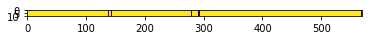

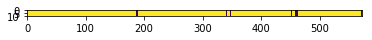

In [56]:
xproj, yproj = xy_projection(poly_sh_arr)

# Calculate cluster number for x/y axis
gap_tol = 0.5 * image_scale
x_ncomps, y_ncomps = estimate_1d_cluster_num(xproj, yproj, gap_tol, False)
print('x comp: {}, y comp: {}'.format(x_ncomps, y_ncomps))

_poly_sh_arr = poly_sh_arr


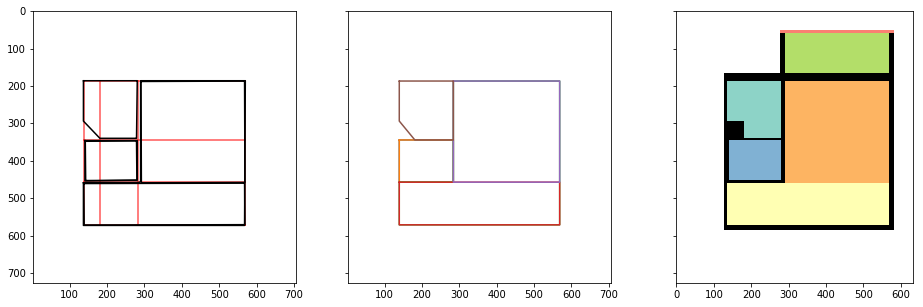

In [86]:
random_seed = 111 
poly_sh_arr = [copy(p) for p in _poly_sh_arr]

# swap axis on yproj to be on xaxis
_FLIP_ORTHO2D_MTX = np.array([[0, 1], [1, 0]])
yproj_swap = yproj @ _FLIP_ORTHO2D_MTX

#tol = 25.0  # door width
#tar_var = (tol / 2) ** 2 
init_var = 2.0     
x_gauss_mod = gauss_mixture_1d(xproj, x_ncomps, init_var, random_seed)
y_gauss_mod = gauss_mixture_1d(yproj_swap, y_ncomps, init_var, random_seed)

# Get clusters
x_means = x_gauss_mod.means_[:, 0]
y_means = y_gauss_mod.means_[:, 0]

# Visualize grid 
f, a = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
a[0] = viz_ortho_snap_grid(x_means, y_means, a[0])
a[0] = viz_poly_sh_arr(poly_sh_arr, a=a[0], color='black', linewidth=1.5)
img = hdata['image'].permute(1, 2, 0) / 255.0
_ = a[0].axis('equal')

cluster_fx = get_cluster_coord_fx(x_gauss_mod, y_gauss_mod)
beps, stol, dpct = 5, 0.25 * image_scale, 0.05
_clean_poly_sh = lambda p: clean_poly_sh(p, beps, stol, dpct)

poly_sh_arr_ = []
for poly_sh in poly_sh_arr:
    
    poly_np = cluster_fx(to_poly_np(poly_sh).T)
    polyc_sh = to_poly_sh(poly_np)
    polyc_sh = _clean_poly_sh(polyc_sh)
    if polyc_sh is None or polyc_sh.area < 1e-10 or polyc_sh.exterior is None:
        continue    
    poly_sh_arr_.append(polyc_sh)
    

a[1] = viz_poly_sh_arr(poly_sh_arr_, a=a[1])
a[1].axis('equal')
a[2].imshow(label_np, cmap='rooms')

poly_sh_arr = poly_sh_arr_

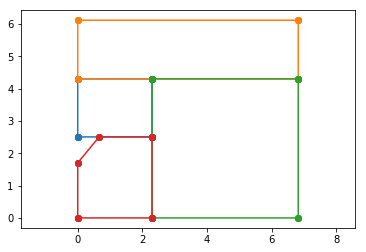

In [58]:

# Scale and shift
# TODO: do this at the beginning after doors. 
_poly_sh_arr = [copy(p) for p in poly_sh_arr]
_poly_sh_arr = move_poly_sh_arr(_poly_sh_arr)
_poly_sh_arr = [affinity.scale(p, meter_scale, meter_scale, origin=(0, 0)) for p in _poly_sh_arr]

viz_poly_sh_arr(_poly_sh_arr, marker='o')

# # Dump polygons as numpy arrays
# floorplan_id = hdata['folder'].split('/')[2]
# floorplan_id = 'floorplan_{}'.format(floorplan_id)
# deeprad_model_dir = os.path.abspath(os.path.join(os.getcwd(), '../..', 'deeprad/data/models/'))

# for i, poly_np in enumerate(poly_np_arr):
#     deeprad_fpath = os.path.join(
#         deeprad_model_dir, floorplan_id, '{}_{}.npy'.format(floorplan_id, i))
#     np.save(deeprad_fpath, poly_np)



